# Visualizador de zonas complementarias 5' RNA - Prot

El primer paso es generar un archivo tabulado con el siguiente formato, conteniendo la informacion de la especie, la secuencia de la proteina, del rna y las secuencias de los hits prot y rna.
<pre>
sp        prot_seq                 rna_seq                                                 prot_hit  rna_hit 
dv1	   M-NNQRKKTGRPSFNMLKRAR	AUG---AACAACCAACGGAAAAAGACGGGACGACCGUCUUUCAAUACUGA...	 FNML	 UCAAUAUGCUG
dv2	   M-NNQRKKARQLPFNMLKRER	AUG---AAUAACCAACGGAAAAAGGCGAGAAACACGCCUUUCAAUACUGA...	 FNML	 UCAAUAUGCUG
</pre>

Estos datos son procesados por el siguiente script de python script de python, que genera las tablas necesarias para ser luego graficadas por ggplot en R.

```python

import pandas as pd
import numpy as np


#carga como df del archivo de entrada, el cual debe tener el formato:
entrada_df= pd.read_table(archivo_entrada)

entrada_df.iloc[:,[1,3]].apply(f, axis=1)

#agrego cuatro columnas con las posiciones iniciales y finales para los hits de proteina y rna.
#primero busca con un rfind, y luego a ese numero le suma el largo del hit.
entrada_df["prot_hit_s"] = entrada_df[["prot_seq", "prot_hit"]].apply(lambda x: x[0].find(x[1]), axis=1)
entrada_df["prot_hit_e"] = entrada_df[["prot_hit", "prot_hit_s"]].apply(lambda x: len(x[0]) + x[1], axis=1)
entrada_df["rna_hit_s"] = entrada_df[["rna_seq", "rna_hit"]].apply(lambda x: x[0].find(x[1]), axis=1)
entrada_df["rna_hit_e"] = entrada_df[["rna_hit", "rna_hit_s"]].apply(lambda x: len(x[0]) + x[1], axis=1)


#subset y separacion de tabla inicial en proteina y rna
prot_df = entrada_df[["sp", "prot_seq", "prot_hit_s", "prot_hit_e"]]
rna_df = entrada_df[["sp", "rna_seq", "rna_hit_s", "rna_hit_e"]]



# ----------------------- #
# reformateo los data frame para obtener un df (para cada uno) con el formato necesario para ggplot,
# esto es una residuo o nucleotido por fila, y una columna color donde 1 es que esa posicion es un hit.


# Proteina
prot_df_salida = pd.DataFrame()
for i in range(len(prot_df)):
    virus = prot_df.iloc[i, 0]
    n_virus = i + 1
    seq_list = list(prot_df.iloc[i, 1])
    l = len(prot_df.iloc[i, 1])
    hit_s = prot_df.iloc[i, 2]
    hit_e = prot_df.iloc[i, 3]
    x = range(1,l + 1)
    tmp = pd.DataFrame({"x": x, "sp_id": [n_virus] * l, "sp": [virus] * l, "seq": seq_list, "color": [0] * l})
    tmp["color"][hit_s:hit_e] = [1] * (hit_e - hit_s)
    prot_df_salida = pd.concat([prot_df_salida, tmp])

# RNA
rna_df_salida = pd.DataFrame()
for i in range(len(rna_df)):
    virus = rna_df.iloc[i, 0]
    n_virus = i + 1
    seq_list = list(rna_df.iloc[i, 1])
    l = len(rna_df.iloc[i, 1])
    l_aa = l / 3
    x_rna = np.array([])
    hit_s = rna_df.iloc[i, 2]
    hit_e = rna_df.iloc[i, 3]
    for e in range(l_aa + 1):
        x_rna = np.append(x_rna, np.array([1.25, 1.5, 1.75]) + e)
    x_rna = x_rna[:l]
    tmp = pd.DataFrame({"x": x_rna, "sp_id": [n_virus] * l, "sp": [virus] * l, "seq": seq_list, "color": [0] * l})
    tmp["color"][hit_s:hit_e] = [2] * (hit_e - hit_s)
    rna_df_salida = pd.concat([rna_df_salida, tmp])

#reordenar las columnas
prot_df_salida = prot_df_salida[["sp", "sp_id", "x", "seq", "color"]]
rna_df_salida = rna_df_salida[["sp", "sp_id", "x", "seq", "color"]]

prot_df_salida.to_csv("/home/fernando/git/flavivirus-disorder/2019/flavivirus/no_X/hit08/visualizador_ali/aa.csv", index=False)
rna_df_salida.to_csv("/home/fernando/git/flavivirus-disorder/2019/flavivirus/no_X/hit08/visualizador_ali/rna.csv", index=False)

```

carga de los datos en R y grafico:

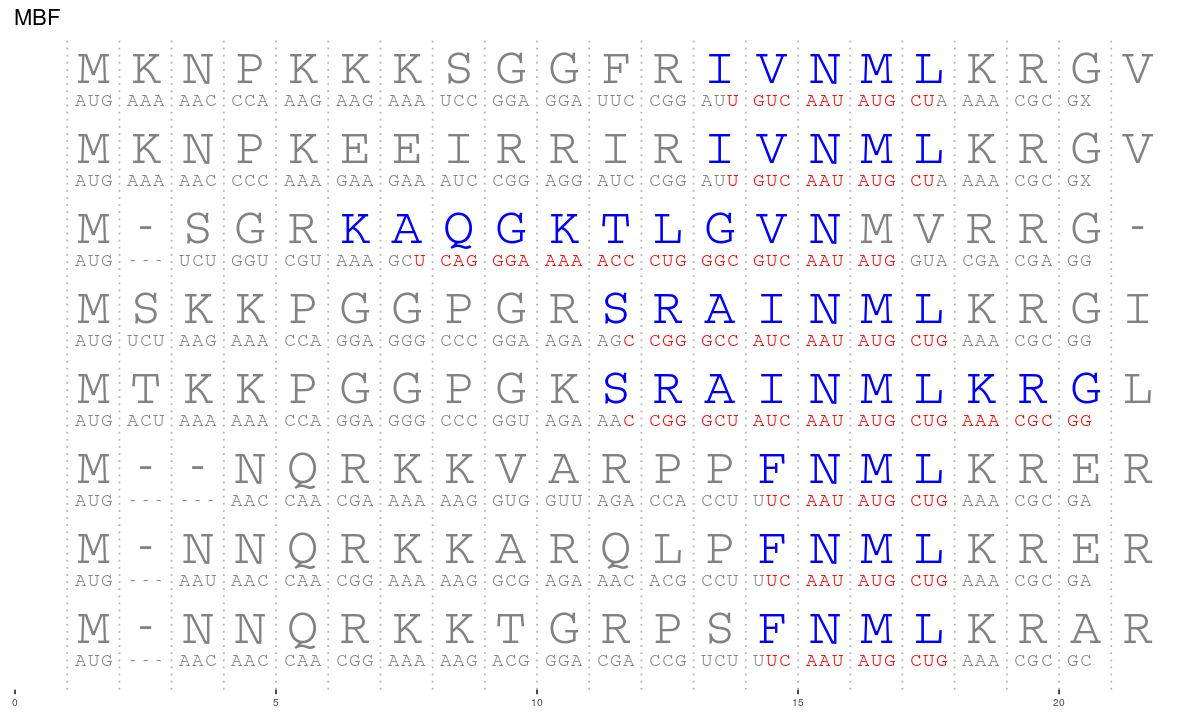

In [9]:
library("ggplot2")
library("repr")

options(repr.plot.width=10, repr.plot.height=6) #tamano grafico salida


df_aa = read.csv( "/home/fernando/git/ag/visualizador_ali/aa.csv", stringsAsFactors = F)
df_rna = read.csv( "/home/fernando/git/ag/visualizador_ali/rna.csv", stringsAsFactors = F)

df_aa$color = as.character(df_aa$color)
df_rna$color = as.character(df_rna$color)
etiquetas <- unique(df_aa$species)
n <- max(df_aa$sp_id)

ggplot() +
  geom_text(data=df_aa, aes(x=x + 0.5, y= sp_id, label=seq, color= color), size=rel(11), family="mono") + # grafica secuencia proteina
  geom_text(data=df_rna, aes(x=x, y=sp_id -  0.4 , label=seq, color= color), size=rel(4), family="mono") + # grafica secuencia rna
  scale_color_manual( values=c("gray51", "blue", "red")) + # gis para las secuencias que no covarian, azul para cov en prot y rojo en rna
  theme(panel.background=element_rect(fill="white", colour="white"),
        axis.title = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_text(family="mono", size=rel(2)),
        axis.text.x = element_text(size=rel(0.7)),
        legend.text = element_text(size=rel(0.7)),
        legend.key.size = unit(0.7, "lines"),
        legend.position = "none") +
  scale_y_continuous(breaks= 1:n, labels = etiquetas) +
  geom_vline(data=df_aa,aes(xintercept =x),linetype="dotted",   color = "gray70", size=0.5) + # linea para visualizar mejor las columnas
  ggtitle("MBF")

